In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from google.colab import drive
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import glob
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Informações sobre o algoritmo.
- Esta é a última parte do trabalho da disciplina de Reconhecimento de Padrões do curso de mestrado em engenharia elétrica da UFJF. Esta parte contém avaliação dos modelos dos classificadores pedidos no trabalho. 
 


# Importando os dados

In [ ]:
# Carrega todos arquivos scv que estão dentro de uma pasta e os armazena em uma lista 
def rot_aux(aux,aux1,ind,ind1):
    df_a   = pd.read_csv(aux1[ind1], skiprows=[0,1,2,3]) # carregar o dataframe que está dentro da pasta 
    rotulo = np.array(aux)[ind][29:len(aux[ind])] # rótulo do banco de dados carregado
    rot    = [] 
    for i in range(len(df_a)):
        rot.append(rotulo)
    df_a['Classes'] = rot # adcionar o rótulo na figura
    return df_a

In [ ]:
# Concatena os arquivos que estão na lista que é obtida pela função rot_aux
def rotular_df(aux,ind): 
    a    = aux[ind] +'/*'
    aux1 = glob.glob(a) #listar as pastas que contém todos os dados de cada exercício
    df = pd.concat([rot_aux(aux,aux1,ind,ind1 = i) for i in range(len(aux1))],ignore_index=True)
    return df

In [ ]:
aux  = glob.glob('/home/antoniojr/notebooks/AReM/*') #listar as pastas que contém todos os dados de cada exercício
df = pd.concat([rotular_df(aux,ind =i) for i in range(len(aux))],ignore_index=True) # dataframe que contém todos os parâmetros 

In [ ]:
df=df.drop('# Columns: time', axis=1) # excluindo a coluna que não tenho interesse ((foi visto que os valores se repetem para cada classe) 

In [ ]:
df['Classes'] = df['Classes'].map({'bending1':0, 'bending2':1, 'cycling':2, 'lying':3, 'sitting':4, 'standing':5,
       'walking':6})

In [ ]:
df.head() # olhando o banco de dados 

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Classes
0,46.25,0.43,18.25,0.43,14.75,0.43,5
1,46.00,0.71,18.50,0.87,14.25,0.83,5
2,46.25,0.83,18.50,0.87,13.75,0.83,5
3,46.25,0.83,18.67,0.47,14.00,0.82,5
4,46.00,1.00,18.50,0.50,13.25,0.83,5


# Separando dados de treinamento e teste

In [ ]:
from sklearn.model_selection import train_test_split 

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df[df.columns[0:-1]], np.ravel(df['Classes']), test_size=0.40, random_state=101)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler       = StandardScaler() 

In [ ]:
X_t     = scaler.fit_transform(X_train1) # dados de treinamento normalizado
X_v     = scaler.fit_transform(X_test1) # dados de teste normalizado

# REDE MLP com a melhor configuação
- 3 camadas ocultas e 86 neurônios em cada camada oculta

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
clf        = MLPClassifier(hidden_layer_sizes=(86,86,86), solver='adam', alpha=1e-5, random_state=1, max_iter=1000)
clf.fit(X_t, y_train1)
y_pred_MLP = clf.predict(X_v)

# Melhor configuração do classificador SVM
- C = 1 , gamma = 1

In [ ]:
from sklearn import svm  #  importar instância que tem o SVM 

In [ ]:
model      = svm.SVC(1,kernel = 'rbf', gamma = 1)  # modelo 
model.fit(X_t, y_train1)
y_pred_svm = model.predict(X_v)

# Rede com kernel RBF

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.preprocessing import OneHotEncoder


#Determinação da rede:
def RBFN(xTrain, yTrain, neurons):
    #Determinar centróide dos clusters: (centro das gaussianas de cada neurônio)
    K_cent = neurons
    km     = KMeans(n_clusters= K_cent, max_iter= 200)
    km.fit(xTrain)
    cent   = km.cluster_centers_
    #Cálculo do sigma:
    dist_vector = distance.pdist(cent,'euclidean')
    dist_matrix = distance.squareform(dist_vector)
    sigma       = dist_matrix.max()/(np.sqrt(2*neurons))
    #Codificando a matriz de labels:
    encoder  = OneHotEncoder()
    yTrain   = encoder.fit_transform(yTrain.reshape(-1,1)).toarray()
    #Cálculo da gaussiana em cada dado de treinamento:
    shape  = xTrain.shape
    row    = shape[0]
    column = neurons
    phi    = np.zeros((row,column), dtype= float)
    for i in range(row):
        for j in range(column):
            dist     = np.linalg.norm(xTrain[i]-cent[j])
            phi[i,j] = np.exp(-(dist**2)/(2*(sigma**2)))
    #Cálculo da pseudo-inversa:
    w = np.linalg.inv(phi.T @ phi) @ (phi.T @ yTrain)
    return w, cent, sigma



In [ ]:
#Eficiência da rede utilizando os valores de w:

def RBFN_score(xTest, yTest, w, cent, sigma):
    row      = xTest.shape[0]
    column   = len(w)
    phiTest  = np.zeros((row,column), dtype= float)
    for i in range(row):
        for j in range(column):
            distTest      = np.linalg.norm(xTest[i]-cent[j])
            phiTest[i,j]  = np.exp(-(distTest**2)/(2*(sigma**2)))
    predTest   = phiTest @ w
    prediction = np.zeros([predTest.shape[0],predTest.shape[1]])
    for i in range(len(predTest)):
        ind = np.where(predTest[i] == max(predTest[i]))
        prediction[i,ind] = 1
    encoder    = OneHotEncoder()
    yTest   = encoder.fit_transform(yTest.reshape(-1,1)).toarray()
    prediction = encoder.inverse_transform(prediction)
    
    return prediction

In [ ]:
w,cent,sigma = RBFN(X_t, y_train1, neurons =141)
saida       = RBFN_score(X_v, y_test1, w, cent, sigma)
#rbf         = np.sum(saida.reshape(1,len(saida)) == y_test1)/len(saida)

# Comparando por acurâcia

In [ ]:
acc = [accuracy_score(y_test1,y_pred_MLP),accuracy_score(y_test1,y_pred_svm),accuracy_score(y_test1,saida)]

(0.7, 0.8)

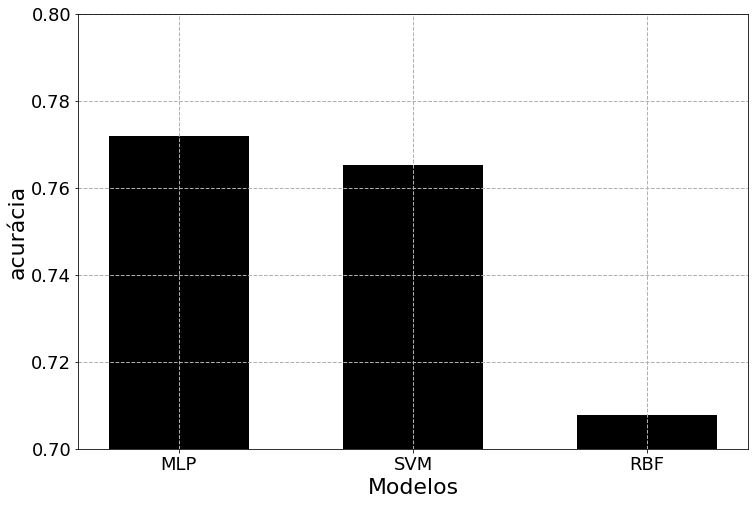

In [ ]:
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.figure(figsize=(12,8))
plt.grid(linestyle='--', linewidth=1)
plt.ylabel('acurácia', size=22)

plt.bar(np.arange(3),np.array(acc),width=0.6, color = 'black')
plt.grid(linestyle='--', linewidth=1)
plt.ylabel('acurácia', size=22)
plt.xlabel('Modelos', size=22)
plt.xticks(np.arange(3) ,('MLP', 'SVM', 'RBF'))

plt.ylim(0.7,0.8)

# Olhando o acerto nas classes por modelos


In [ ]:
MLP_cl = np.diagonal(confusion_matrix(y_test1,y_pred_MLP))/np.sum(confusion_matrix(y_test1,y_pred_MLP),axis = 0)
SVM_cl = np.diagonal(confusion_matrix(y_test1,y_pred_svm))/np.sum(confusion_matrix(y_test1,y_pred_svm),axis = 0)
SBF_cl = np.diagonal(confusion_matrix(y_test1,saida))/np.sum(confusion_matrix(y_test1,saida), axis = 0)


In [ ]:
x = np.arange(len(MLP_cl))

(0.5, 0.96)

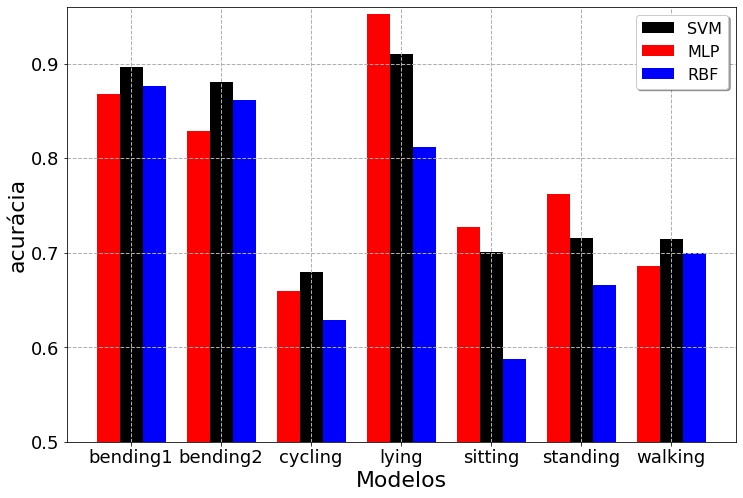

In [ ]:
plt.rc('ytick', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.figure(figsize=(12,8))

w = 0.255

plt.bar(x + w,SVM_cl, width=0.25, color='black', align='center',label ='SVM')
plt.bar(x,MLP_cl, width=0.25, color='red', align='center', label = 'MLP')
plt.bar(x+2*w,SBF_cl, width=0.25, color='blue', align='center', label ='RBF')
plt.xticks([i + 0.25 for i in x ], ['bending1','bending2','cycling','lying','sitting','standing','walking'])
plt.legend(loc='upper right', shadow=True, fontsize=16)
plt.grid(linestyle='--', linewidth=1)
plt.ylabel('acurácia', size=22)
plt.xlabel('Modelos', size=22)
plt.ylim(0.5,0.96)

Se for olhar o modelo que acerta mais dados, o melhor modelo é a rede MLP, mas se for olhar aquele que acerta mais classes, o classificador que acerta  mais classes é o SVM. Já que o SVM ganha em 4 classes, e a MLP ganha em 3.
